# PINN Learning of Burgers' Equation

\begin{equation}
    u_t + \lambda u u_x = \eta u_{xx}
\end{equation}

Using data provided alongside the original PINN paper (see README) with $\lambda = 1$ and $\eta = 0.01 / \pi$

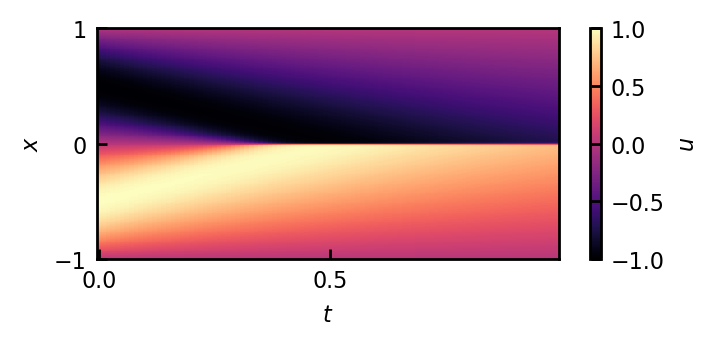

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('../../figure_style.mplstyle')

# Load data
data = loadmat('../data/burgers_shock.mat')
U_star = data['usol']
t_star = data['t']
x_star = data['x']

N = x_star.shape[0]
T = t_star.shape[0]

dt = t_star[1,0] - t_star[0,0]
dx = x_star[1,0] - x_star[0,0]

# Reshape data
XX = np.tile(x_star[:,0:1], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

# Plot data
def plot_field(ax, u, vmin, vmax, label=None):
    im = ax.pcolormesh(TT, XX, u, cmap='magma', vmin=vmin, vmax=vmax)
    ax.set(xlabel='$t$', xticks=[0, 0.5],
           ylabel='$x$', ylim=[-1,1], yticks=[-1, 0, 1],
           aspect=0.25)
    plt.colorbar(im, ax=ax, label=label)

fig, ax = plt.subplots(1,1, figsize=(4,1.5))
plot_field(ax, U_star, vmin=-1, vmax=1, label='$u$')

## Solve a Boundary Value Problem

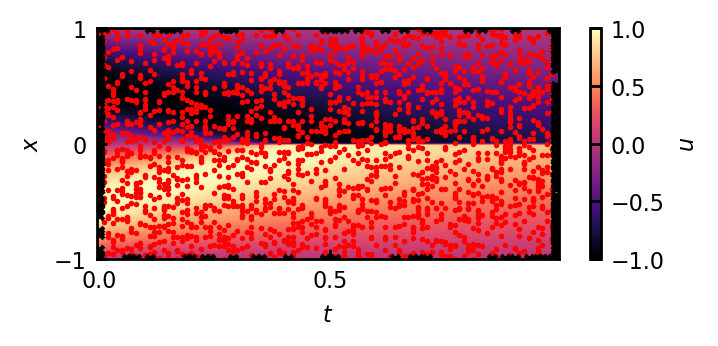

In [2]:
# Select points for bulk physics-informed loss
N_f = 2000
idx = np.random.choice(N*T, N_f, replace=False)
x_f, t_f, u_f = x[idx,:], t[idx,:], u[idx,:]

# Select boundary points for reconstruction loss
N_b = 200
idx = np.argwhere(np.logical_or(
    np.logical_or(x == x.min(), x == x.max()),
    np.logical_or(t == t.min(), t == t.max())
))[:,0]
idx = np.random.choice(idx, N_b, replace=False)
x_b, t_b, u_b = x[idx,:], t[idx,:], u[idx,:]

# Plot both sets of points
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
plot_field(ax, U_star, vmin=-1, vmax=1, label='$u$')
ax.scatter(t_f, x_f, c='red', s=1)
ax.scatter(t_b, x_b, c='black', marker='x', s=10)

In [7]:
import torch
from burgers_pinn import BurgersBVPPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = BurgersBVPPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
        x_b=x_b,
        t_b=t_b,
        u_b=u_b
    ),
    log_dir="./tb_logs/Burgers/BVP"
).to(device)
model.train(1)

Starting to train on device cuda:0
Iteration 1000, Loss: 3.47579e-03, MSE: 1.87092e-03, Phys: 1.60486e-03
Iteration 2000, Loss: 8.90053e-04, MSE: 5.14860e-04, Phys: 3.75193e-04
Iteration 3000, Loss: 3.73872e-04, MSE: 2.53357e-04, Phys: 1.20514e-04
Iteration 4000, Loss: 2.69621e-04, MSE: 2.03415e-04, Phys: 6.62062e-05
Iteration 5000, Loss: 2.06015e-04, MSE: 1.52375e-04, Phys: 5.36398e-05
Iteration 6000, Loss: 1.56706e-04, MSE: 1.12284e-04, Phys: 4.44224e-05
Iteration 7000, Loss: 1.16848e-04, MSE: 8.23803e-05, Phys: 3.44675e-05
Iteration 8000, Loss: 8.22209e-05, MSE: 5.60457e-05, Phys: 2.61753e-05
Iteration 9000, Loss: 6.06022e-05, MSE: 4.21246e-05, Phys: 1.84776e-05
Iteration 10000, Loss: 4.67405e-05, MSE: 3.62711e-05, Phys: 1.04694e-05
Iteration 11000, Loss: 4.19230e-05, MSE: 3.46914e-05, Phys: 7.23159e-06
Iteration 12000, Loss: 3.92743e-05, MSE: 3.34211e-05, Phys: 5.85315e-06
Iteration 13000, Loss: 3.77452e-05, MSE: 3.29188e-05, Phys: 4.82636e-06


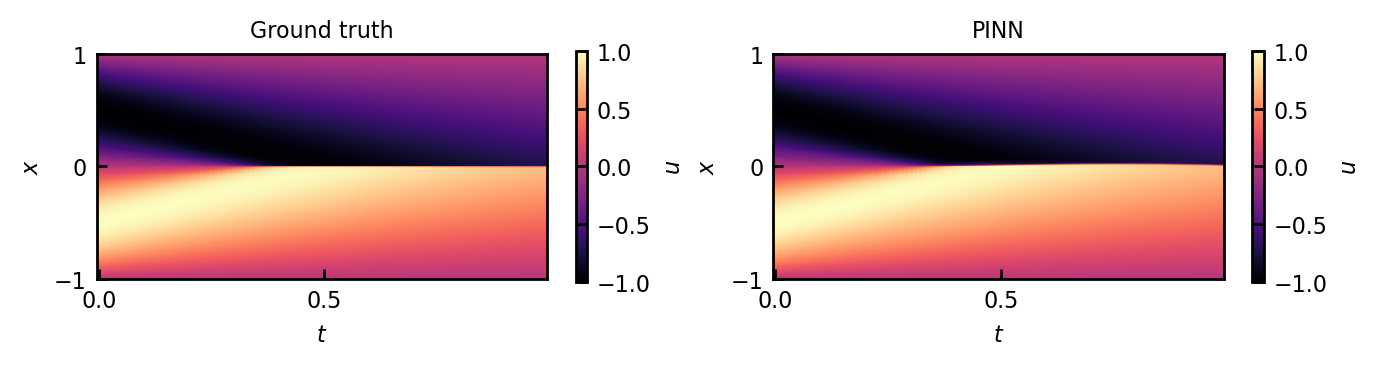

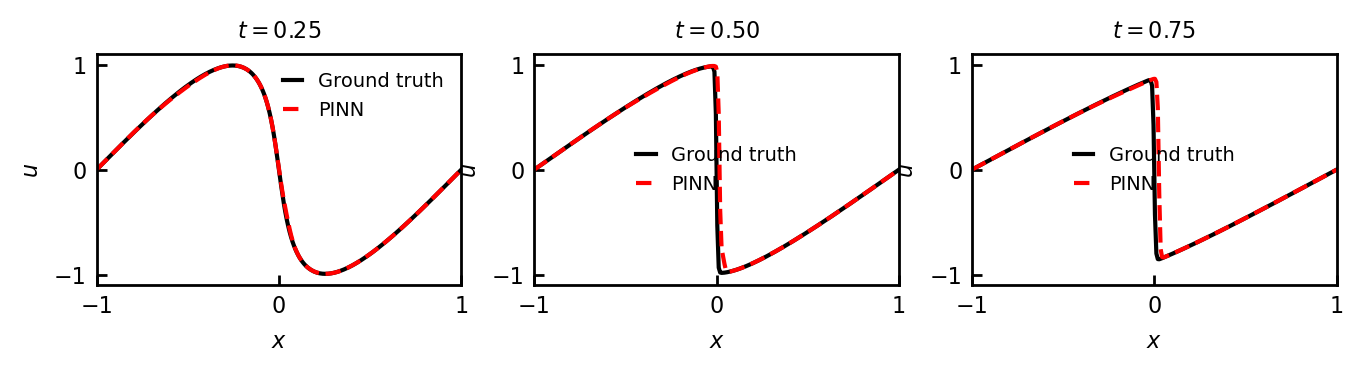

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star, vmin=-1, vmax=1, label='$u$')
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred, vmin=-1, vmax=1, label='$u$')
ax[1].set_title('PINN')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[-1, 1], xticks=[-1, 0, 1], 
          ylabel='$u$', ylim=[-1.1, 1.1], yticks=[-1, 0, 1])
    a.legend()

## Estimate unknown parameters $\lambda, \eta$

In [5]:
import torch
from burgers_pinn import BurgersBVPPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

from burgers_pinn import BurgersParameterPINN

model = BurgersParameterPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
    ),
    log_dir="./tb_logs/Burgers/Parameter"
).to(device)
model.train(1)

Iteration 1000, Loss: 3.20194e-03, MSE: 2.27809e-03, Phys: 9.23853e-04
Iteration 2000, Loss: 6.88837e-04, MSE: 4.64252e-04, Phys: 2.24585e-04
Iteration 3000, Loss: 1.63759e-04, MSE: 7.75609e-05, Phys: 8.61981e-05
Iteration 4000, Loss: 7.00242e-05, MSE: 2.57616e-05, Phys: 4.42627e-05
Iteration 5000, Loss: 4.16162e-05, MSE: 1.50305e-05, Phys: 2.65857e-05
Iteration 6000, Loss: 2.74964e-05, MSE: 9.02407e-06, Phys: 1.84724e-05
Iteration 7000, Loss: 1.82132e-05, MSE: 5.35529e-06, Phys: 1.28579e-05
Iteration 8000, Loss: 1.27107e-05, MSE: 3.73297e-06, Phys: 8.97770e-06
Iteration 9000, Loss: 9.11847e-06, MSE: 2.36845e-06, Phys: 6.75002e-06
Iteration 10000, Loss: 6.68332e-06, MSE: 1.77671e-06, Phys: 4.90662e-06


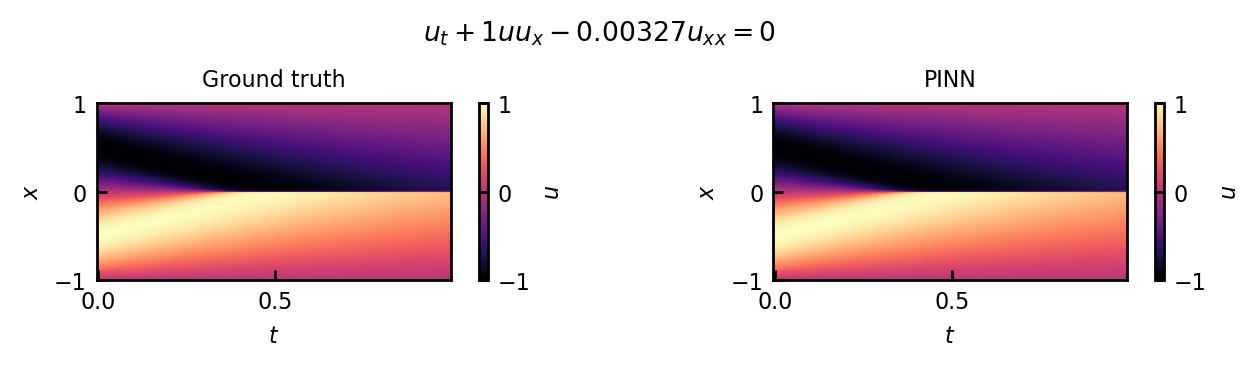

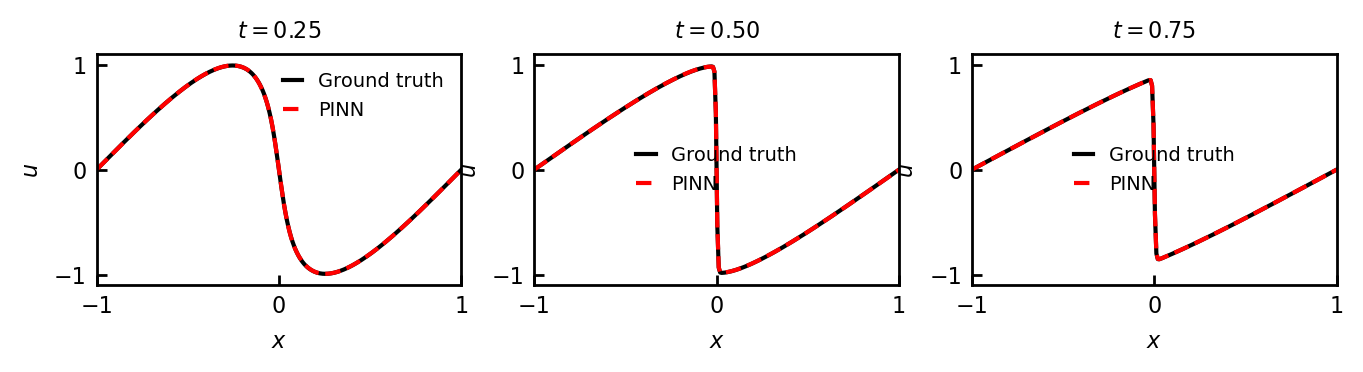

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star, vmin=-1, vmax=1, label='$u$')
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred, vmin=-1, vmax=1, label='$u$')
ax[1].set_title('PINN')

fig.subplots_adjust(top=0.7)
fig.suptitle(f'$u_t + {model.params[0].detach().item():.3g} u u_x - {model.params[1].exp().detach().item():.3g} u_{{xx}} = 0$')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[-1, 1], xticks=[-1, 0, 1], 
          ylabel='$u$', ylim=[-1.1, 1.1], yticks=[-1, 0, 1])
    a.legend()